In [2]:
# ==========================================
# CELLA 1: CONFIGURAZIONE E BOOTSTRAP (FIXED)
# ==========================================
import os
import sys
import shutil

# =============================================================================
# 1. ENVIRONMENT SANITIZATION (Reset)
# =============================================================================
print(">>> Executing Environment Reset (Clean Slate)...")
try:
    os.chdir('/content/')
    # Usiamo shutil per una rimozione più sicura in ambiente Python
    if os.path.exists('Hawk-AI-CV-Project'):
        shutil.rmtree('Hawk-AI-CV-Project')
except Exception as e:
    print(f"Note: Reset non necessario o errore minore: {e}")

# =============================================================================
# 2. SOURCE CODE RETRIEVAL (Clone)
# =============================================================================
print(">>> Cloning Repository...")
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# =============================================================================
# 3. RUNTIME CONTEXT & PATH CONFIGURATION
# =============================================================================
repo_name = "Hawk-AI-CV-Project"
%cd {repo_name}

# Iniettiamo la root del progetto nel PATH per gli import assoluti
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

# =============================================================================
# 4. DEPENDENCY RESOLUTION
# =============================================================================
print(">>> Installing Runtime Dependencies...")
# Forziamo l'aggiornamento per evitare conflitti di versione tra numpy e opencv
!pip install --upgrade numpy opencv-python matplotlib pandas

# =============================================================================
# 5. VERIFICATION & ASSET CHECK (Cruciale per il debug)
# =============================================================================
print("\n>>> Setup Complete. Active Runtime Root:")
print(os.getcwd())

try:
    import numpy as np
    import cv2 as cv
    import pandas as pd
    print(f">>> Dependencies verified: OpenCV {cv.__version__} | Numpy {np.__version__}")

    # Check se i file necessari sono presenti
    file_necessari = ['src/config.py', 'src/homography_calculator.py']
    for f in file_necessari:
        if os.path.exists(f):
            print(f"✅ File di sistema trovato: {f}")
        else:
            print(f"❌ ATTENZIONE: File mancante: {f}")

except ImportError as e:
    print(f"!!! CRITICAL ERROR: Dependency installation failed - {e}")

# =============================================================================
# NOTA PER IL PROSSIMO STEP:
# Una volta eseguita questa cella, passami la cella dove definisci
# la logica di 'is_point_in' e 'HawkEyeJudge'.
# =============================================================================

>>> Executing Environment Reset (Clean Slate)...
>>> Cloning Repository...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 845 (delta 31), reused 0 (delta 0), pack-reused 775 (from 2)
Receiving objects: 100% (845/845), 83.55 MiB | 29.58 MiB/s, done.
Resolving deltas: 100% (361/361), done.
/content/Hawk-AI-CV-Project
>>> Installing Runtime Dependencies...

>>> Setup Complete. Active Runtime Root:
/content/Hawk-AI-CV-Project
>>> Dependencies verified: OpenCV 4.13.0 | Numpy 2.4.1
✅ File di sistema trovato: src/config.py
✅ File di sistema trovato: src/homography_calculator.py


In [3]:
# ==========================================
# CELLA 2: CONFIGURAZIONE GIUDICE E LOGICA SPAZIALE
# ==========================================
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Dimensioni Standard ITF (International Tennis Federation)
# Area Calibrata: Rettangolo di Servizio (Near Service Box)
# X: Larghezza Singolo (8.23m)
# Y: Distanza Baseline -> Service Line (5.485m)
# -----------------------------------------------------------------------------
# NOTA SULLE TOLLERANZE:
# Le linee del campo sono larghe circa 5cm. Aggiungiamo 10cm di buffer
# per compensare errori di precisione della YOLO e dello spessore delle righe.
# -----------------------------------------------------------------------------
COURT_DIMENSIONS = {
    'X_MIN': -0.10,   'X_MAX': 8.33,   # 8.23 + buffer
    'Y_MIN': -0.10,   'Y_MAX': 5.585   # 5.485 + buffer
}

def is_point_in(x, y):
    """
    Valuta se le coordinate proiettate nel mondo reale (metri) sono entro i limiti.
    """
    if x is None or y is None:
        return False

    in_x = (COURT_DIMENSIONS['X_MIN'] <= x <= COURT_DIMENSIONS['X_MAX'])
    in_y = (COURT_DIMENSIONS['Y_MIN'] <= y <= COURT_DIMENSIONS['Y_MAX'])

    return in_x and in_y

print(f"✅ Configurazione Giudice Completata.")
print(f"   Area di monitoraggio: X[{COURT_DIMENSIONS['X_MIN']}m a {COURT_DIMENSIONS['X_MAX']}m]")
print(f"                        Y[{COURT_DIMENSIONS['Y_MIN']}m a {COURT_DIMENSIONS['Y_MAX']}m]")

✅ Configurazione Giudice Completata.
   Area di monitoraggio: X[-0.1m a 8.33m]
                        Y[-0.1m a 5.585m]


In [4]:
# =============================================================================
# MODULE: HAWK-EYE JUDICIAL ENGINE (M3) - UPDATED
# =============================================================================
import cv2 as cv
import numpy as np

# Sincronizziamo COURT_DIMENSIONS con i limiti ITF + buffer di tolleranza
COURT_DIMENSIONS = {
    'X_MIN': -0.10,   'X_MAX': 8.33,
    'Y_MIN': -0.10,   'Y_MAX': 5.585
}

def is_point_in(x, y):
    """
    Ritorna True se il punto (x,y) in metri è dentro il rettangolo di servizio.
    """
    if x is None or y is None: return False
    return (COURT_DIMENSIONS['X_MIN'] <= x <= COURT_DIMENSIONS['X_MAX'] and
            COURT_DIMENSIONS['Y_MIN'] <= y <= COURT_DIMENSIONS['Y_MAX'])

class HawkEyeJudge:
    def __init__(self, homography_matrix):
        self.H = np.array(homography_matrix, dtype=np.float32)

    def pixel_to_world(self, u, v):
        """
        Usa cv.perspectiveTransform per una proiezione più stabile.
        """
        # Creiamo il punto in formato (1, 1, 2) richiesto da OpenCV
        src_pt = np.array([[[u, v]]], dtype=np.float32)

        # Applichiamo la trasformazione prospettica
        dst_pt = cv.perspectiveTransform(src_pt, self.H)

        # Estraiamo X e Y in metri
        wx = dst_pt[0][0][0]
        wy = dst_pt[0][0][1]

        return wx, wy

    def detect_bounces(self, trajectory):
        """
        Rilevamento rimbalzi basato sull'inversione della velocità verticale (Vy).
        """
        bounces = []
        if len(trajectory) < 5: return bounces

        last_bounce_frame = -20
        for t in range(2, len(trajectory) - 2):
            prev, curr, nxt = trajectory[t-1], trajectory[t], trajectory[t+1]
            if prev is None or curr is None or nxt is None: continue

            # Vy > 0 significa che la pallina scende (pixel Y aumentano)
            v_vel_in  = curr[1] - prev[1]
            v_vel_out = nxt[1] - curr[1]

            # Inversione: scende (in > 0) e poi sale (out < 0)
            if v_vel_in > 1.5 and v_vel_out <= 0:
                if (t - last_bounce_frame) > 15:
                    bounces.append({'frame': t, 'pixel': curr})
                    last_bounce_frame = t
        return bounces

    def adjudicate_video(self, video_path, trajectory, output_path):
        cap = cv.VideoCapture(video_path)
        fps = cap.get(cv.CAP_PROP_FPS)
        w, h = int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        out = cv.VideoWriter(output_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

        bounces = self.detect_bounces(trajectory)
        print(f"🎾 Eventi di impatto rilevati: {len(bounces)}")

        decisions = {}
        for b in bounces:
            f_idx = b['frame']
            px, py = b['pixel']

            # STEP 3: Parallasse - Spostiamo il punto di proiezione alla base della pallina
            # Se py_contact produce valori wy troppo alti, riduciamo l'offset.
            py_contact = py + 4

            wx, wy = self.pixel_to_world(px, py_contact)

            if wx is not None:
                verdict = "IN" if is_point_in(wx, wy) else "OUT"
                decisions[f_idx] = {
                    'verdict': verdict,
                    'coords': (wx, wy),
                    'color': (0, 255, 0) if verdict == "IN" else (0, 0, 255)
                }
                # Debug log fondamentale per capire la proiezione
                print(f"   -> Frame {f_idx:3d} | Pixel: ({px:4.0f}, {py_contact:4.0f}) | World: (X={wx:5.2f}m, Y={wy:5.2f}m) | Verdetto: {verdict}")

        frame_count = 0
        display_timer = 0
        current_display = None

        while True:
            ret, frame = cap.read()
            if not ret: break

            if frame_count in decisions:
                current_display = decisions[frame_count]
                display_timer = int(fps * 2)

            # Traiettoria (Pallina Gialla)
            if frame_count < len(trajectory) and trajectory[frame_count] is not None:
                cv.circle(frame, (int(trajectory[frame_count][0]), int(trajectory[frame_count][1])), 4, (0, 255, 255), -1)

            # Overlay Risultato
            if display_timer > 0 and current_display:
                cv.rectangle(frame, (40, 40), (400, 160), (0,0,0), -1)
                cv.putText(frame, current_display['verdict'], (60, 110), cv.FONT_HERSHEY_SIMPLEX, 2, current_display['color'], 5)
                cv.putText(frame, f"X:{current_display['coords'][0]:.2f}m Y:{current_display['coords'][1]:.2f}m", (60, 145), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
                display_timer -= 1

            out.write(frame)
            frame_count += 1

        cap.release()
        out.release()
        print(f"✅ Video salvato in: {output_path}")

In [5]:
# ==========================================
# CELLA 3: ESECUZIONE DEL GIUDICE (CORREZIONE SCALA 2880x1800)
# ==========================================
import pandas as pd
import numpy as np
import glob
import os
import cv2 as cv
from google.colab import files

# 1. MATRICE H (Calibrata su 1075x613)
H_MATRIX = np.array([
    [ 6.50980565e-02,  2.65116930e-02, -3.04981716e+01],
    [ 3.86372362e-04, -1.97434738e-01,  7.91002378e+01],
    [ 1.76143090e-04,  6.49680276e-03,  1.00000000e+00]
])

# 2. CONFIGURAZIONE RISOLUZIONI (Cruciale!)
CALIBRATION_W, CALIBRATION_H = 1075, 613
VIDEO_RES_W, VIDEO_RES_H = 2880, 1800  # La risoluzione del tuo video originale

# -----------------------------------------------------------

print("🚀 Inizializzazione Hawk-Eye Judicial Engine...")
judge = HawkEyeJudge(H_MATRIX)

csv_files = glob.glob("DATI_*.csv")

for csv_path in csv_files:
    print(f"\n" + "="*50)
    nome_base = os.path.basename(csv_path).replace("DATI_", "").replace(".csv", "")

    # Cerca il video
    video_path = f"/content/Hawk-AI-CV-Project/{nome_base}.mov"
    if not os.path.exists(video_path):
        video_path = f"{nome_base}.mov"

    if os.path.exists(video_path):
        print(f"✅ Analisi: {nome_base} ({VIDEO_RES_W}x{VIDEO_RES_H})")

        df = pd.read_csv(csv_path)
        trajectory_list = [None] * (int(df['frame'].max()) + 100)

        # Calcolo fattori di scala per riportare il video alla calibrazione
        # Se i pixel nel CSV sono già 2880x1800, li rimpiccioliamo per la matrice H
        scale_u = CALIBRATION_W / VIDEO_RES_W
        scale_v = CALIBRATION_H / VIDEO_RES_H

        for _, row in df.iterrows():
            f = int(row['frame'])
            u = float(row['u']) * scale_u
            v = float(row['v']) * scale_v

            if not (np.isnan(u) or np.isnan(v)):
                trajectory_list[f] = (u, v)

        # ESECUZIONE GIUDIZIO
        output_name = f"FINAL_JUDGE_{nome_base}.mp4"
        judge.adjudicate_video(video_path, trajectory_list, output_name)

        if os.path.exists(output_name):
            files.download(output_name)

🚀 Inizializzazione Hawk-Eye Judicial Engine...

✅ Analisi: video1 (2880x1800)
🎾 Eventi di impatto rilevati: 4
   -> Frame  16 | Pixel: ( 413,  392) | World: (X= 1.88m, Y= 0.52m) | Verdetto: IN
   -> Frame  49 | Pixel: ( 593,  208) | World: (X= 5.55m, Y=15.53m) | Verdetto: OUT
   -> Frame  65 | Pixel: ( 693,  142) | World: (X= 8.99m, Y=25.19m) | Verdetto: OUT
   -> Frame 100 | Pixel: ( 410,  293) | World: (X= 1.33m, Y= 7.20m) | Verdetto: OUT
✅ Video salvato in: FINAL_JUDGE_video1.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

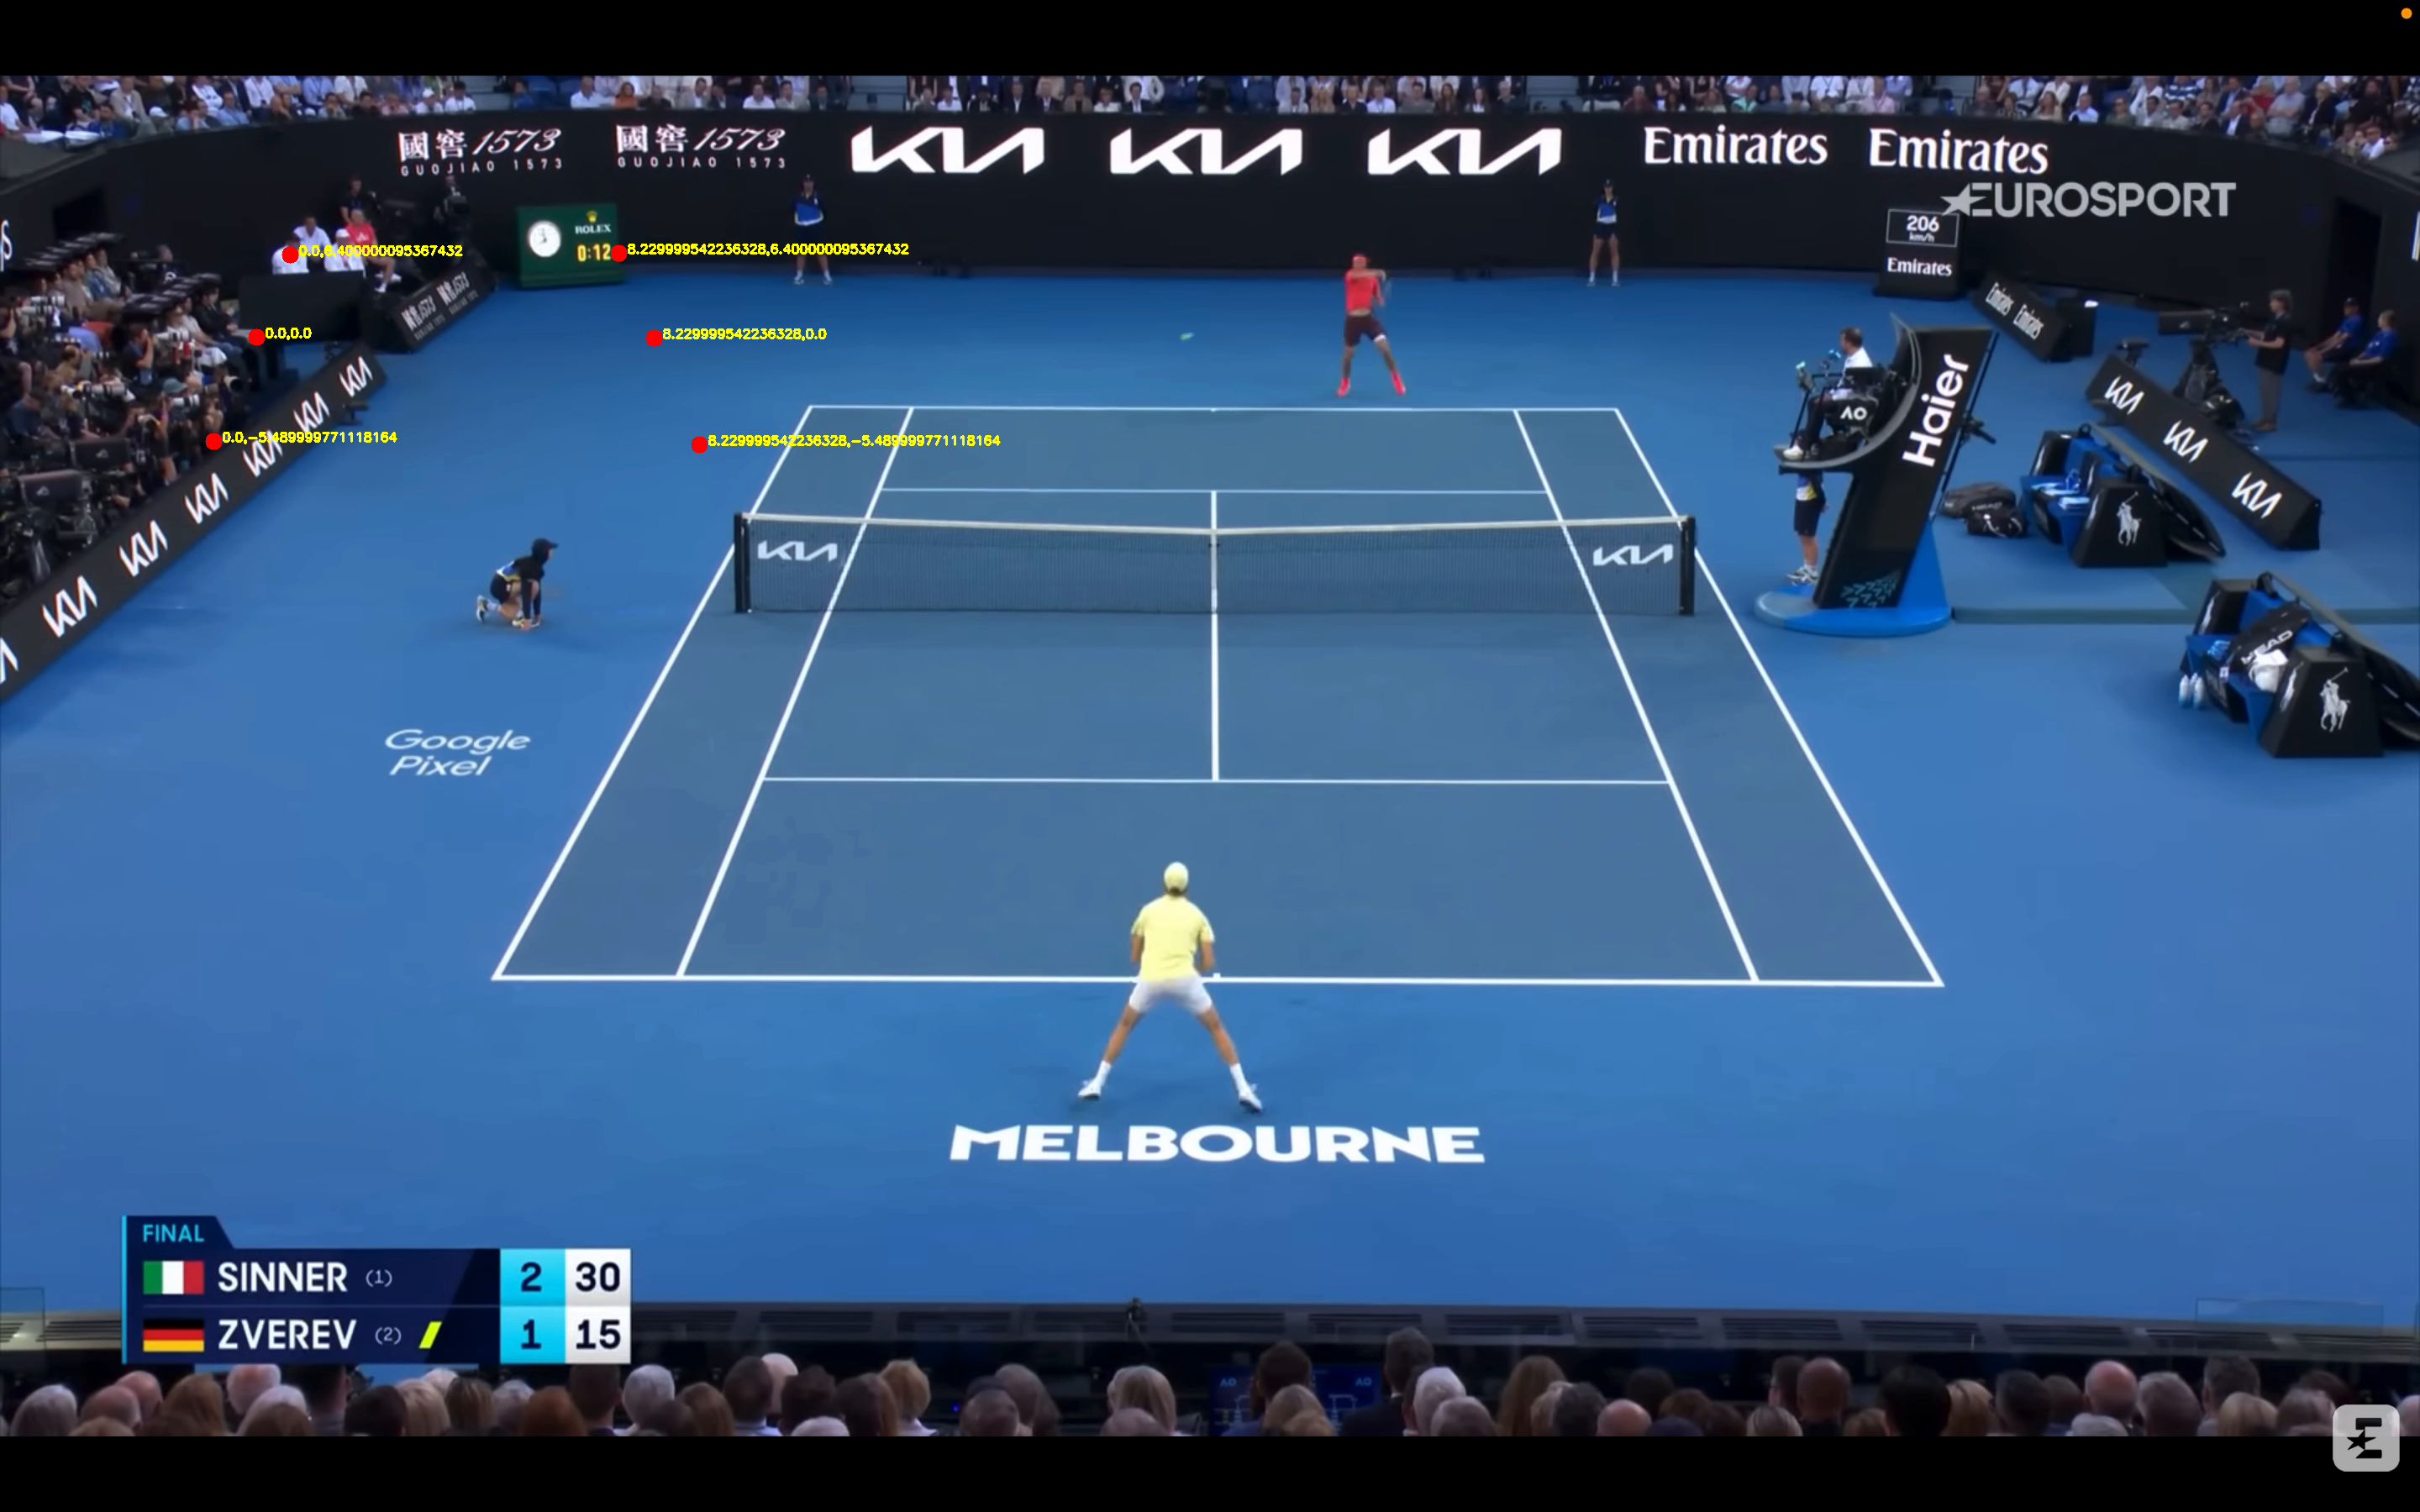

In [6]:
# ==========================================
# CELLA DI DEBUG: VISUALIZZA LA GRIGLIA
# ==========================================
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

H_MATRIX = np.array([
    [6.50980565e-02, 2.65116930e-02, -3.04981716e+01],
    [3.86372362e-04, -1.97434738e-01, 7.91002378e+01],
    [1.76143090e-04, 6.49680276e-03, 1.00000000e+00]
])

# 2. Definiamo i 4 angoli del campo (in METRI) secondo il sistema M3
# Ordine: [0,0] (Servizio SX), [8.23, 0] (Servizio DX), [8.23, 6.40] (Rete DX), [0, 6.40] (Rete SX)
# Usiamo i punti chiave delle righe del singolare
punti_metri = np.array([
    [0.0,  0.0],   # Intersezione T servizio / laterale sinistra
    [8.23, 0.0],   # Intersezione T servizio / laterale destra
    [8.23, 6.40],  # Rete / laterale destra
    [0.0,  6.40],  # Rete / laterale sinistra
    [0.0, -5.49],  # Fondo / laterale sinistra
    [8.23, -5.49]  # Fondo / laterale destra
], dtype='float32')

def disegna_campo_su_frame(frame, H):
    # Calcoliamo l'inversa per proiettare Metri -> Pixel
    try:
        H_inv = np.linalg.inv(H)
    except:
        print("La matrice non è invertibile!")
        return frame

    # Convertiamo i punti metri in coordinate omogenee [x, y, 1] h, w = frame.shape[:2]
    pts_pixel = []

    for pm in punti_metri:
        vec_m = np.array([pm[0], pm[1], 1])
        vec_px = np.dot(H_inv, vec_m)

        # Normalizza
        if vec_px[2] != 0:
            u = int(vec_px[0] / vec_px[2])
            v = int(vec_px[1] / vec_px[2])
            pts_pixel.append((u, v))

            # Disegna punto
            cv.circle(frame, (u, v), 10, (0, 0, 255), -1)
            cv.putText(frame, f"{pm[0]},{pm[1]}", (u+10, v), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)

    return frame

# --- TEST SU UN FRAME A CASO DEL TUO VIDEO ---
video_path = "video1.mov" # <--- CONTROLLA NOME FILE
cap = cv.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    frame_debug = disegna_campo_su_frame(frame, H_MATRIX)
    cv2_imshow(frame_debug)
else:
    print("Impossibile leggere il video per il debug.")
cap.release()